In [1]:
from scgenome import tantalus
import pandas as pd
from IPython.display import display
from scgenome import utils, cncluster, simulation, cnplot, jointcnmodels
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time
import sklearn.metrics as skm

def get_mixture_labels(cn_data, obs_name="bhc_cluster_id", exp_name="origin_id_int"):
    sub_cn_data = cn_data[["cell_id", obs_name, exp_name]].drop_duplicates()
    return sub_cn_data

In [2]:
cn_data_fp = "/Users/massoudmaher/data/sc1935to37_spike_in_chrX.csv"
cn_data = pd.read_csv(cn_data_fp).iloc[:,1:]

In [3]:
cn_data.head(10)
cn_data = cn_data[cn_data["end"] <= 5000000]

In [4]:
hmmcopy_tickets = ['SC-1935', 'SC-1936', 'SC-1937']
sample_ids = [["SA922"], ['SA921'], ['SA1090']]

# spike in params
total_ncells = 100
proportions = [0.3, 0.3, 0.4]

# bhc params
n_states = 8
alpha = 3
prob_cn_change = 0.9
bhc_incon = 2 # inconsistent score used for making clusters from bhc
bhc_depth = 2 

# naive clusering params
naive_method = "complete"
naive_metric = "cityblock"
naive_incon = 1.1
naive_depth = 2

# Params for testing threshold values
params = simulation.expand_grid({"transform":["log","none"], "criterion": ["inconsistent"], "threshold": np.arange(0.025, 2, step=0.05)})
params = pd.concat([params, simulation.expand_grid({"transform":["log","none"], "criterion": ["distance"], "threshold": np.arange(3, 20, step=1)})])

In [5]:
start = time.time()
bhc_linkage, bhc_root, bhc_cell_ids, matrix_data, measurement, variances = (
    cncluster.bayesian_cluster(cn_data, n_states=n_states, alpha=alpha, prob_cn_change=prob_cn_change,
                               clustering_id="copy", debug=True)
)
print(f"{time.time()-start}s for BHC on {total_ncells} cells")

8.17903184890747s for BHC on 100 cells


/Users/massoudmaher/Documents/Code/scgenome/scg/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


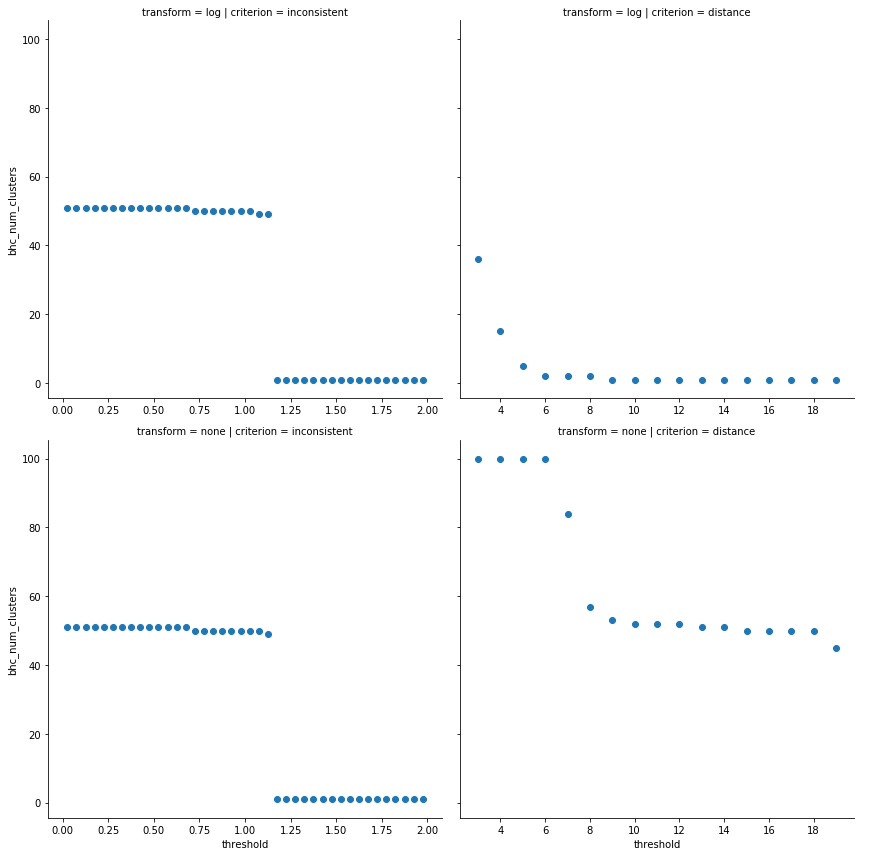

In [6]:
bhc_linkage, bhc_plot_data = simulation.get_plot_data(bhc_linkage)
lbhc_plot_data = bhc_plot_data.copy()
lbhc_plot_data[:,2] = np.log(bhc_plot_data[:,2]) # Log because the highest link is way higher

def apply_fn(row):
    if row["transform"] == "log":
        df = lbhc_plot_data
    else:
        df = bhc_plot_data
    return sch.fcluster(df, row["threshold"], criterion=row["criterion"])
params["bhc_fcluster"] = params.apply(apply_fn, axis=1)
params["bhc_num_clusters"] = params["bhc_fcluster"].apply(lambda x: len(set(x)))

g = sns.FacetGrid(data=params, col="criterion", row="transform", size=6, sharey=True, sharex=False).add_legend()
g = g.map(plt.scatter, "threshold", "bhc_num_clusters")

idx: [76 72 82 56 99 80 86 53 59 81 49 89 47 91 85 92 73 61 54 64 41 96 83 94
 52 98 74 55 46 66 57 88 44 93 63 69 25 97 95 79 78 50 60 51 75 45 68 42
 71 40 77 70 65 48 87 43 67 10 58 35 33 27 32 18 37 29 24 11 31 22 28 20
 23  8 34  5 84 19 90 14 39 30  7  1 36  9 16  6 15 12 17  3 38 26 13  4
 62  2 21  0]
homogeneity: 0.4168683047615191, completeness: 0.667254482852669, v-measure: 0.5131471237191729


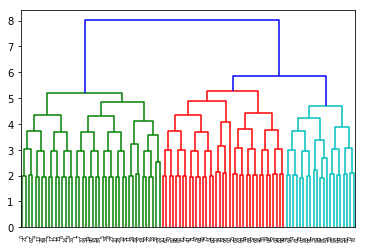

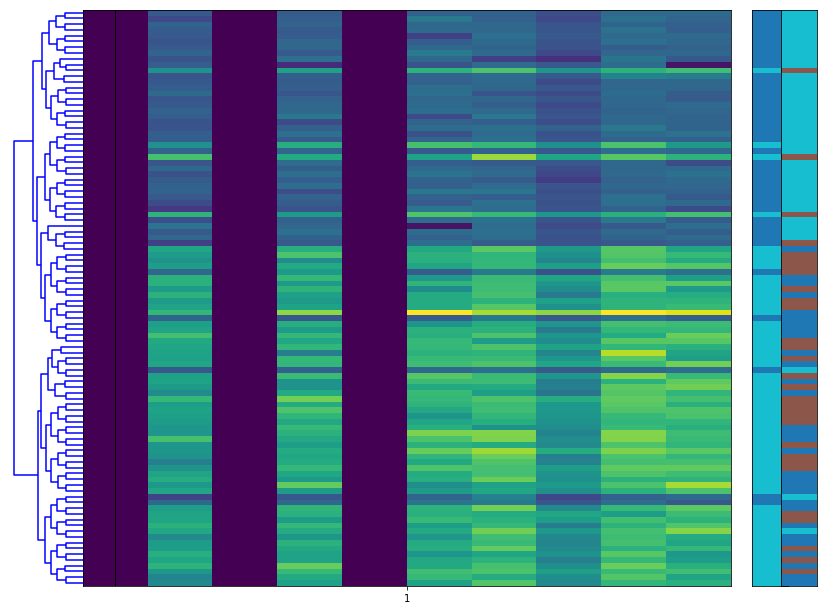

In [7]:
dend = sch.dendrogram(lbhc_plot_data)

bhc_clusters = sch.fcluster(lbhc_plot_data, 8, criterion="distance")
assert len(set(bhc_clusters)) > 1
cn_data = cncluster.prune_cluster(bhc_clusters, bhc_cell_ids, cn_data)
cn_data["origin_id_int"] = cn_data["origin_id"].factorize()[0]

fig = plt.figure(figsize=(10, 8))
bimatrix_data = cnplot.plot_clustered_cell_cn_matrix_figure(
    fig, cn_data, "copy", cluster_field_name="bhc_cluster_id",
    linkage=lbhc_plot_data, origin_field_name="origin_id_int", raw=True, flip=True)
clabels = get_mixture_labels(cn_data)
scores = skm.homogeneity_completeness_v_measure(clabels["origin_id_int"], clabels["bhc_cluster_id"])
print(f"homogeneity: {scores[0]}, completeness: {scores[1]}, v-measure: {scores[2]}")

In [8]:
display(bimatrix_data.iloc[:,0:13]) 

cell_id           SA1090-A96213A-R29-C56 SA1090-A96213A-R24-C15  \
bhc_cluster_id                         1                      1   
origin_id_int                          2                      2   
cell_order                            0                      1    
chr_index start                                                   
22        1                     0.000000               0.000000   
          500001                0.805486               0.653688   
          1000001               0.000000               0.000000   
          1500001               0.840587               0.887902   
          2000001               0.000000               0.000000   
          2500001               0.930098               1.193840   
          3000001               0.925087               0.919853   
          3500001               0.699545               0.654493   
          4000001               1.032388               1.092607   
          4500001               1.028632               0.967279   

cell_id           SA1090-A96213A-R33-C32 SA1090-A96213A-R31-C42  \
bhc_cluster_id                         1                      1   
origin_id_int                          2                      2   
cell_order                            2                      3    
chr_index start                                                   
22        1                     0.000000               0.000000   
          500001                0.950338               0.871272   
          1000001               0.000000               0.000000   
          1500001               0.953597               0.849967   
          2000001               0.000000               0.000000   
          2500001               1.008205               1.031977   
          3000001               1.007359               0.996968   
          3500001               0.795765               0.800119   
          4000001               0.961965               1.119458   
          4500001               0.916815               0.890796   

cell_id           SA1090-A96213A-R33-C34 SA1090-A96213A-R24-C22  \
bhc_cluster_id                         1                      1   
origin_id_int                          2                      2   
cell_order                            4                      5    
chr_index start                                                   
22        1                     0.000000               0.000000   
          500001                0.827410               0.779900   
          1000001               0.000000               0.000000   
          1500001               0.865002               0.986975   
          2000001               0.000000               0.000000   
          2500001               0.583807               0.890039   
          3000001               1.091759               1.033820   
          3500001               0.842108               0.758594   
          4000001               1.026764               1.091658   
          4500001               1.036692               0.983685   

cell_id           SA1090-A96213A-R28-C69 SA1090-A96213A-R28-C38  \
bhc_cluster_id                         1                      1   
origin_id_int                          2                      2   
cell_order                            6                      7    
chr_index start                                                   
22        1                     0.000000               0.000000   
          500001                0.842599               0.953921   
          1000001               0.000000               0.000000   
          1500001               0.981573               0.836189   
          2000001               0.000000               0.000000   
          2500001               0.992526               1.226352   
          3000001               0.957995               1.023791   
          3500001               0.759554               0.660841   
          4000001               0.880577               0.984872   
          4500001               0.946436    

In [26]:
cn_data[cn_data["cell_id"] == "SA1090-A96213A-R29-C56"]

,chr,start,end,reads,gc,copy,state,cell_id,sample_id,library_id,origin_id,origin_id_int,bhc_cluster_id
30789,X,1,500000,237,-1.000000,NaN,1,SA1090-A96213A-R29-C56,SA1090,A96213A,SC-1937,2,1
30790,X,500001,1000000,372,0.458294,0.805486,1,SA1090-A96213A-R29-C56,SA1090,A96213A,SC-1937,2,1
30791,X,1000001,1500000,214,-1.000000,NaN,1,SA1090-A96213A-R29-C56,SA1090,A96213A,SC-1937,2,1
30792,X,1500001,2000000,406,0.481712,0.840587,1,SA1090-A96213A-R29-C56,SA1090,A96213A,SC-1937,2,1
30793,X,2000001,2500000,369,-1.000000,NaN,1,SA1090-A96213A-R29-C56,SA1090,A96213A,SC-1937,2,1
30794,X,2500001,3000000,420,0.448584,0.930098,1,SA1090-A96213A-R29-C56,SA1090,A96213A,SC-1937,2,1
30795,X,3000001,3500000,378,0.414510,0.925087,1,SA1090-A96213A-R29-C56,SA1090,A96213A,SC-1937,2,1
30796,X,3500001,4000000,307,0.437568,0.699545,1,SA1090-A96213A-R29-C56,SA1090,A96213A,SC-1937,2,1
30797,X,4000001,4500000,365,0.379672,1.032388,1,SA1090-A96213A-R29-C56,SA1090,A96213A,SC-1937,2,1
30798,X,4500001,5000000,352,0.373268,1.028632,1,SA1090-A96213A-R29-C56,SA1090,A96213A,SC-1937,2,1


In [9]:
order = np.array([76,72,82,56,99,80,86,53,59,81,49,89,47,91,85,92,73,61,54,64,41,96,83,94
,52,98,74,55,46,66,57,88,44,93,63,69,25,97,95,79,78,50,60,51,75,45,68,42
,71,40,77,70,65,48,87,43,67,10,58,35,33,27,32,18,37,29,24,11,31,22,28,20
,23,8,34,5,84,19,90,14,39,30,7,1,36,9,16,6,15,12,17,3,38,26,13,4
,62,2,21,0])
measurement[np.flip(order),0:5]

array([[       nan, 0.75660721,        nan, 0.69002424,        nan],
       [       nan, 0.59861268,        nan, 0.80560332,        nan],
       [       nan, 0.49157069,        nan, 0.77398303,        nan],
       [       nan, 0.5699561 ,        nan, 0.82923255,        nan],
       [       nan, 0.65368824,        nan, 0.88790181,        nan],
       [       nan, 0.78907356,        nan, 1.05636922,        nan],
       [       nan, 0.83901397,        nan, 1.0022918 ,        nan],
       [       nan, 0.82263518,        nan, 0.87607218,        nan],
       [       nan, 0.74441599,        nan, 1.08317773,        nan],
       [       nan, 0.80548562,        nan, 0.84058692,        nan],
       [       nan, 0.68024778,        nan, 0.8658833 ,        nan],
       [       nan, 0.95392103,        nan, 0.83618879,        nan],
       [       nan, 0.99661142,        nan, 0.87391357,        nan],
       [       nan, 0.84259933,        nan, 0.98157346,        nan],
       [       nan, 1.03332233,   

odd_cell is "SA921-A90554A-R15-C52", repeat process on subset of cells

In [10]:
keep_cells = bimatrix_data.iloc[:,0:11].columns.get_level_values(0)
scn_data = cn_data[cn_data["cell_id"].isin(keep_cells)].reset_index(drop=True)
print(keep_cells)

Index(['SA1090-A96213A-R29-C56', 'SA1090-A96213A-R24-C15',
       'SA1090-A96213A-R33-C32', 'SA1090-A96213A-R31-C42',
       'SA1090-A96213A-R33-C34', 'SA1090-A96213A-R24-C22',
       'SA1090-A96213A-R28-C69', 'SA1090-A96213A-R28-C38',
       'SA1090-A96213A-R27-C64', 'SA1090-A96213A-R35-C12',
       'SA921-A90554A-R15-C52'],
      dtype='object', name='cell_id')


r at li: 0
    0         1         2         3         4         5         6         7   \
0  NaN -6.994418 -8.060248 -7.034799 -7.029581 -7.049196 -6.984935 -7.004003   
1  NaN       NaN -8.047279 -6.955108 -6.949871 -6.970370 -6.903143 -6.923121   
2  NaN       NaN       NaN -8.000255 -7.999071 -7.982533 -8.049330 -8.023492   
3  NaN       NaN       NaN       NaN -6.989489 -7.008911 -6.945413 -6.964164   
4  NaN       NaN       NaN       NaN       NaN -7.003842 -6.940171 -6.958980   
5  NaN       NaN       NaN       NaN       NaN       NaN -6.960816 -6.979086   
6  NaN       NaN       NaN       NaN       NaN       NaN       NaN -6.913227   
7  NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
8  NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
9  NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
10 NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

          8          9      

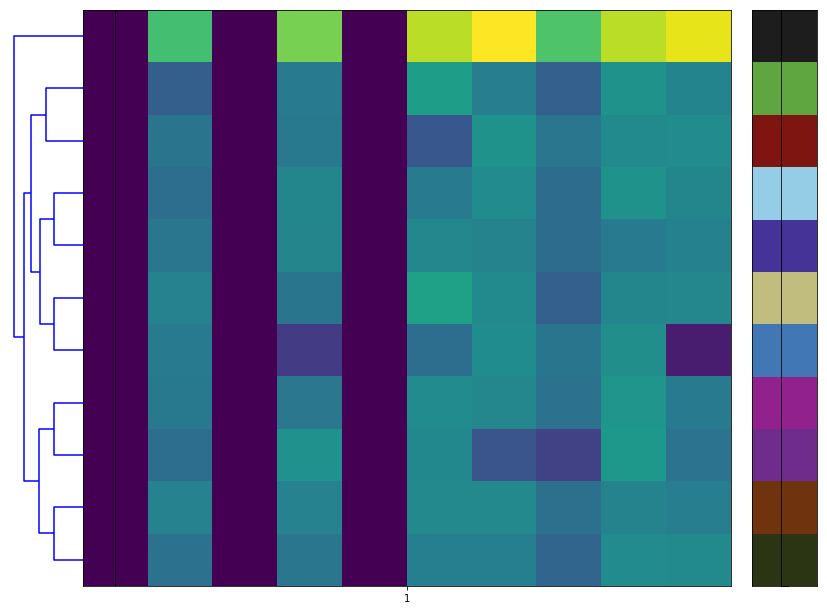

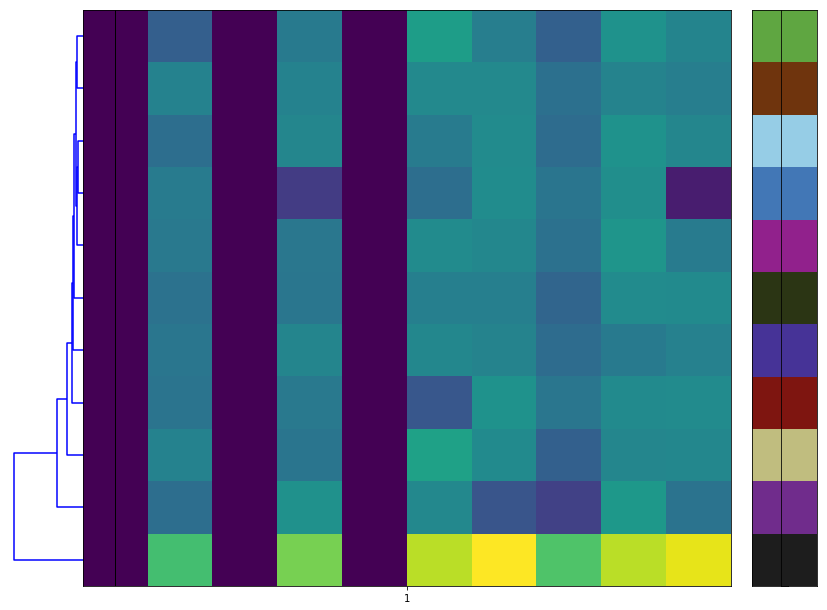

In [11]:
#scn_data = pd.read_csv("/Users/massoudmaher/data/scn_data.csv")

slinkage, sroot, scell_ids, smatrix_data, smeasurement, svariances = (
    cncluster.bayesian_cluster(scn_data, n_states=n_states, alpha=alpha, prob_cn_change=prob_cn_change,
                               clustering_id="copy", debug=True, print_r=True)
)

slinkage, splot_data = simulation.get_plot_data(slinkage)
lsplot_data = splot_data.copy()
lsplot_data[:,2] = np.log(splot_data[:,2]) # Log because the highest link is way higher

scn_data["origin_id_int"] = scn_data["cell_id"].factorize()[0]
scn_data["bhc_cluster_id"] = scn_data["cell_id"].factorize()[0]

fig = plt.figure(figsize=(10, 8))
bimatrix_data = cnplot.plot_clustered_cell_cn_matrix_figure(
    fig, scn_data, "copy", cluster_field_name="bhc_cluster_id",
    linkage=lsplot_data, origin_field_name="origin_id_int", raw=True, 
    flip=False)

nlinkage = sch.linkage(np.nan_to_num(smeasurement, 0))

fig = plt.figure(figsize=(10, 8))
bimatrix_data = cnplot.plot_clustered_cell_cn_matrix_figure(
    fig, scn_data, "copy", cluster_field_name="bhc_cluster_id",
    linkage=nlinkage, origin_field_name="origin_id_int", raw=True)

In [12]:
pd.DataFrame(smeasurement)

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.653688,0.0,0.887902,0.0,1.193840,0.919853,0.654493,1.092607,0.967279
1,0.0,0.779900,0.0,0.986975,0.0,0.890039,1.033820,0.758594,1.091658,0.983685
2,0.0,0.773332,0.0,1.087141,0.0,1.003948,0.563760,0.417079,1.148719,0.821638
3,0.0,0.953921,0.0,0.836189,0.0,1.226352,1.023791,0.660841,0.984872,0.991131
4,0.0,0.842599,0.0,0.981573,0.0,0.992526,0.957995,0.759554,0.880577,0.946436
5,0.0,0.805486,0.0,0.840587,0.0,0.930098,0.925087,0.699545,1.032388,1.028632
6,0.0,0.871272,0.0,0.849967,0.0,1.031977,0.996968,0.800119,1.119458,0.890796
7,0.0,0.950338,0.0,0.953597,0.0,1.008205,1.007359,0.795765,0.961965,0.916815
8,0.0,0.827410,0.0,0.865002,0.0,0.583807,1.091759,0.842108,1.026764,1.036692
9,0.0,0.895479,0.0,0.380792,0.0,0.780006,1.041139,0.833951,1.057388,0.174067


In [25]:
bhc_cell_ids[17]

'SA1090-A96213A-R29-C56'

In [13]:
def get_cell_id_col(inds, ids):
    lids = list(ids)
    size = len(lids)
    lids.append("cluster")
    inds[inds >= size] = size
    return pd.Series(lids).iloc[list(inds)].reset_index(drop=True)
#bhc_linkage["i_id"] = bhc_cell_ids[list(bhc_linkage["i"])]
#display(bhc_linkage)
bhc_linkage["i_id"] = get_cell_id_col(bhc_linkage["i"], bhc_cell_ids)
bhc_linkage["j_id"] = get_cell_id_col(bhc_linkage["j"], bhc_cell_ids)
slinkage["i_id"] = get_cell_id_col(slinkage["j"], scell_ids)
slinkage["j_id"] = get_cell_id_col(slinkage["j"], scell_ids)

/Users/massoudmaher/Documents/Code/scgenome/scg/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [14]:
bhc_linkage.head()

,i,j,r_merge,naive_dist,log_like,i_count,j_count,pi,d,result_ind,...,ll_right,pi_left,pi_right,tree_ll,tree_ll_left,tree_ll_right,merge_count,dist,i_id,j_id
0,49,81,-6.799363,NaN,7.02921,1,1,-1.38629,2.48491,100,...,6.86411,0,0,12.4423,5.86474,6.86411,2,6.799363,SA921-A90554A-R05-C18,SA922-A90554B-R28-C66
1,73,92,-6.864191,NaN,7.31837,1,1,-1.38629,2.48491,101,...,6.49322,0,0,12.7963,6.58969,6.49322,2,6.864191,SA922-A90554B-R25-C43,SA922-A90554B-R32-C12
2,27,33,-6.891532,NaN,17.7275,1,1,-1.38629,2.48491,102,...,12.2097,0,0,23.2328,11.3098,12.2097,2,6.891532,SA1090-A96213A-R33-C31,SA1090-A96213A-R34-C41
3,18,32,-6.892806,NaN,16.7887,1,1,-1.38629,2.48491,103,...,11.8536,0,0,22.2952,10.7283,11.8536,2,6.892806,SA1090-A96213A-R31-C37,SA1090-A96213A-R34-C38
4,19,84,-6.894923,NaN,14.0854,1,1,-1.38629,2.48491,104,...,9.40725,0,0,19.5941,10.4735,9.40725,2,6.894923,SA1090-A96213A-R31-C42,SA922-A90554B-R29-C42


In [15]:
slinkage.iloc[:5,4:]

,log_like,i_count,j_count,pi,d,result_ind,d_left,d_right,ll_left,ll_right,pi_left,pi_right,tree_ll,tree_ll_left,tree_ll_right,merge_count,dist,i_id,j_id
0,14.4868,1,1,-1.38629,2.48491,11,1.09861,1.09861,9.81686,10.4735,0,0,20.0037,9.81686,10.4735,2,6.903143,SA1090-A96213A-R31-C42,SA1090-A96213A-R31-C42
1,16.2849,1,1,-1.38629,2.48491,12,1.09861,1.09861,9.62824,12.516,0,0,21.8575,9.62824,12.516,2,6.958980,SA1090-A96213A-R33-C32,SA1090-A96213A-R33-C32
2,11.0492,1,1,-1.38629,2.48491,13,1.09861,1.09861,8.41139,8.54721,0,0,16.6718,8.41139,8.54721,2,7.008911,SA1090-A96213A-R29-C56,SA1090-A96213A-R29-C56
3,8.37508,1,1,-1.38629,2.48491,14,1.09861,1.09861,6.90395,7.69564,0,0,14.3126,6.90395,7.69564,2,7.323784,SA1090-A96213A-R33-C34,SA1090-A96213A-R33-C34
4,0.225327,1,1,-1.38629,2.48491,15,1.09861,1.09861,5.28491,6.00894,0,0,11.0062,5.28491,6.00894,2,12.167140,SA1090-A96213A-R35-C12,SA1090-A96213A-R35-C12


In [16]:
display(smeasurement[:5,:5])
display(measurement[:5,:5])

array([[0.        , 0.65368824, 0.        , 0.88790181, 0.        ],
       [0.        , 0.77989989, 0.        , 0.98697545, 0.        ],
       [0.        , 0.77333159, 0.        , 1.0871411 , 0.        ],
       [0.        , 0.95392103, 0.        , 0.83618879, 0.        ],
       [0.        , 0.84259933, 0.        , 0.98157346, 0.        ]])

array([[       nan, 0.75660721,        nan, 0.69002424,        nan],
       [       nan, 0.88828107,        nan, 0.8506272 ,        nan],
       [       nan, 0.49157069,        nan, 0.77398303,        nan],
       [       nan, 0.74441599,        nan, 1.08317773,        nan],
       [       nan, 0.65368824,        nan, 0.88790181,        nan]])

In [17]:
jointcnmodels.calculate_marginal_ll_simple(smeasurement[[1],:], svariances[[1],:], {"kind":"twoparam","e0":0.8,"e1":0.2})

4.656227114100659

In [18]:
include_cells = ["SA1090-A96213A-R33-C15", 'SA921-A90554A-R04-C52', 'SA922-A90554B-R27-C44', 'SA922-A90554B-R30-C42']
small_cn = cn_data[cn_data["cell_id"].isin(include_cells)]

In [19]:
sm_linkage, sm_root, sm_cell_ids, sm_matrix_data, sm_measurement, sm_variances = (
    cncluster.bayesian_cluster(small_cn, n_states=n_states, alpha=alpha, prob_cn_change=prob_cn_change,
                               clustering_id="copy")
)

In [20]:
sm_linkage

,i,j,r_merge,naive_dist,log_like,i_count,j_count,merge_count
0,1,3,-7.57013,NaN,4.04122,1,1,2
1,0,2,-8.77426,NaN,0.683172,1,1,2
2,5,4,-22.7992,NaN,-2.4236,2,2,4


In [21]:
sm_cell_ids

cell_id
SA1090-A96213A-R33-C15    SA1090-A96213A-R33-C15
SA921-A90554A-R04-C52      SA921-A90554A-R04-C52
SA922-A90554B-R27-C44      SA922-A90554B-R27-C44
SA922-A90554B-R30-C42      SA922-A90554B-R30-C42
Name: cell_id, dtype: object

In [34]:
np.where(bhc_cell_ids.to_numpy() == "SA921-A90554A-R15-C52")

(array([69]),)

In [35]:
bhc_cell_ids[25]

'SA1090-A96213A-R33-C15'

In [30]:
cn_data[cn_data["cell_id"] == "SA1090-A96213A-R28-C69"]

,chr,start,end,reads,gc,copy,state,cell_id,sample_id,library_id,origin_id,origin_id_int,bhc_cluster_id
27057,X,1,500000,216,-1.000000,NaN,1,SA1090-A96213A-R28-C69,SA1090,A96213A,SC-1937,2,1
27058,X,500001,1000000,334,0.458294,0.842599,1,SA1090-A96213A-R28-C69,SA1090,A96213A,SC-1937,2,1
27059,X,1000001,1500000,133,-1.000000,NaN,1,SA1090-A96213A-R28-C69,SA1090,A96213A,SC-1937,2,1
27060,X,1500001,2000000,390,0.481712,0.981573,1,SA1090-A96213A-R28-C69,SA1090,A96213A,SC-1937,2,1
27061,X,2000001,2500000,330,-1.000000,NaN,1,SA1090-A96213A-R28-C69,SA1090,A96213A,SC-1937,2,1
27062,X,2500001,3000000,391,0.448584,0.992526,1,SA1090-A96213A-R28-C69,SA1090,A96213A,SC-1937,2,1
27063,X,3000001,3500000,360,0.414510,0.957995,1,SA1090-A96213A-R28-C69,SA1090,A96213A,SC-1937,2,1
27064,X,3500001,4000000,296,0.437568,0.759554,1,SA1090-A96213A-R28-C69,SA1090,A96213A,SC-1937,2,1
27065,X,4000001,4500000,301,0.379672,0.880577,1,SA1090-A96213A-R28-C69,SA1090,A96213A,SC-1937,2,1
27066,X,4500001,5000000,316,0.373268,0.946436,1,SA1090-A96213A-R28-C69,SA1090,A96213A,SC-1937,2,1
